### Notebook setup

#### Import shunpiker pre-set packages and modules
 
For an introduction to python packages and modules, see https://realpython.com/python-modules-packages/#python-packages.    

In [1]:
# import shunpiker pre-set packages and modules
%run shunpiker_modules.py

scanpy==1.8.2 anndata==0.7.6 umap==0.5.2 numpy==1.20.3 scipy==1.7.1 pandas==1.3.4 scikit-learn==1.0.1 statsmodels==0.13.0 python-igraph==0.9.8 pynndescent==0.5.5
phenograph== 1.5.7


💡 **Hint:** Use the code below ONLY if you need to install extra packages

In [2]:
#import sys
#!{sys.executable} -m pip install watermark

#### Set notebook parameters

[`%matplotlib inline`](https://ipython.readthedocs.io/en/stable/interactive/tutorial.html#magics-explained) sets output of plotting commands to be displayed directly below the code cell that produced it.


<a id='part_1'></a>

In [3]:
# display plot directly below code cell
%matplotlib inline

## Multi-sample integration

This part guides multisample integration. Make sure that you have run **Step 1** for each of your samples to remove bad quality cells on a per sample basis and store cells of interest for sample integration.

### Read in scRNA-seq raw counts into a python object (multiple samples)

❗ Choose between [cellranger](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/output/overview) and [SEQC](https://github.com/dpeerlab/seqc) data format for your input

Both data inputs will be converted into a scRNA-seq friendly python object called an AnnData object. The AnnData object is  is made up of several components. For a more detailed explanation, see https://anndata.readthedocs.io/en/latest/anndata.AnnData.html#anndata.AnnData. 

Once you execute either of the input commands below, you should be able to access:
- counts: `adata.X` + Run
- gene names: `adata.var` + Run
- cell index and other annotation: `adata.obs` + Run

#### Input SEQC data

🕹️  Provide the path to your raw data and the name of your sample

In [4]:
# type path to your SEQC data folder (replace example path with your path)
path_to_seqc_data = '../data/'

In [5]:
sample_names = ['3001_MAIT_healthy_IGO_12381_49_dense.csv', '3004_MAIT_patients_IGO_12381_55_dense.csv']

Now apply the import_seqc_function to each of these samples. Make sure the combination of the PATH_TO_COUNT_CSV in the import_seqc_data function, combined with each of your sample names, results in the correct paths. The result of the command below will be a list of AnnData objects in the order of your sample names. Reading the csvs might take a few minutes per sample.

In [6]:
adatas_list = [import_seqc_data(path_to_seqc_data, sample) for sample in sample_names] # this may take a few minutes

In [7]:
adata = sc.AnnData.concatenate(
    *adatas_list, # the asterisk unpacks the list containing your AnnData objects. 
    join='outer', 
    batch_key = 'sample', 
    batch_categories = ['MAIT_healthy', 'MAIT_patients'], # or use your sample_names list (as used above) here. 
    # Make sure the order of the batch categories matches that of the AnnData objects 
    index_unique = '.'
)

In [8]:
# randomize the order of cells for plotting
adata.X = np.array(pd.DataFrame(adata.X).fillna(0)) # fill NAs with 0s
np.random.seed(42) 
index_list = np.arange(adata.shape[0])
np.random.shuffle(index_list)
adata = adata[index_list]

In [9]:
adata.shape

(36243, 19266)

### Calculate quality control metrics for your sample before preprocessing

To start, we will calculate some standard quality control (QC) metrics using the `calc_QC_metrics()` function that is defined within the `shunpiker_modules.py` file. The QC metrics calculated include total counts, number of genes, and ribosomal and mitochondrial fraction on a per cell basis.

In [10]:
# caclutate QC metrics for your sample
calc_QC_metrics(adata)

Trying to set attribute `.obs` of view, copying.


❗To check if the QC metrics are now available for your sample, you can run the command below and inspect the column names.

In [11]:
# show top 5 rows from sample metadata (stored in adata.obs)
adata.obs.head()

,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,original_total_counts,log10_original_total_counts,mito_frac,RBP_frac
cell_barcodes,,,,,,,,,,,,,
165789560137948.MAIT_patients,MAIT_patients,1551,7.347300,4995.0,8.516393,39.259259,53.433433,64.284284,78.158158,4995.0,3.698535,0.089489,0.287888
157071998933292.MAIT_patients,MAIT_patients,1910,7.555382,5396.0,8.593598,30.485545,43.847294,55.300222,70.144552,5396.0,3.732072,0.035397,0.275575
197264019479980.MAIT_healthy,MAIT_healthy,1423,7.261225,4785.0,8.473451,41.044932,57.533960,67.795193,80.710554,4785.0,3.679882,0.044305,0.415883
135083779844406.MAIT_healthy,MAIT_healthy,1071,6.977281,3462.0,8.149891,41.854419,59.272097,71.259388,83.506644,3462.0,3.539327,0.059503,0.421144
230731478329126.MAIT_patients,MAIT_patients,797,6.682109,2666.0,7.888710,47.224306,64.403601,75.168792,88.859715,2666.0,3.425860,0.033758,0.495499


### Data "clean-up": removal of not expressed genes

Genes with zero counts across all cells will not provide any biological insight, but rather delay some of the downstream processing steps, thus we choose to remove genes that are not expressed in any cells. You can make this step more stringend by asking genes to be expressed in at least N number of cells.

In [12]:
# remove genes that are not expressed in any cells (remove columns with all 0s)
sc.pp.filter_genes(adata, min_cells=1)

### Data "clean-up": removal of rRNA

Ribosomal protein (RBP) RNA often constitutes between 20-50% of your counts. Variation in their expression can therefore highly affect the outcome of your visualization algorithms and differential gene expression analyses. Our experience is that expression levels of RBP RNA often cannot be reproduced or validated, and are moreover difficult to interpret. One can therefore decide to remove these genes from the data altogether.

In [13]:
adata = remove_RBs(adata)

### Data "clean-up": data normalization

RNA counts generally vary linearly with library size: RNA molecules have a steady concentration rather than a steady absolute number (Additional variation suggests biological variation in gene expression among your cells). Therefore, it is usually appropriate to normalize each cell to the same total library size, thereby converting RNA counts to a relative rather than absolute count. Below a random gene is plotted against library size to show that expression, at least if not variable between cell types in your sample, changes according to library size. We take a gene with a minimum gene expression of 1, because trends in genes with low mean expression are occluded by noise. Run the cell below a few times to inspect the general trend between gene expression and library size. Note that scRNA-seq data is highly noisy, and the correlation will therefore be noisy as well in genes with lower expression.

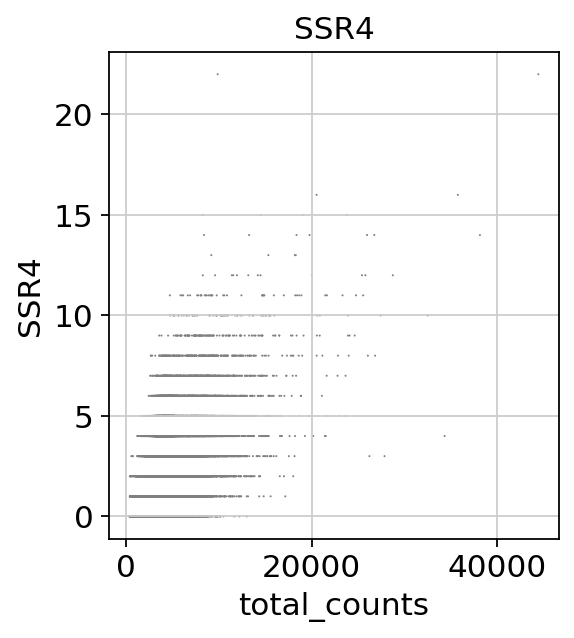

In [14]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
observe_library_size_effect(adata)

An alternative method to normalize data is using SCRAN that applies a similar principle to common normalization methods in bulk RNA data.

Here we will normalize to a total library size of 10,000. Scanpy will update our count matrix (adata.X) automatically with the normalized counts.

In [15]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=10**4)

Trying to set attribute `.obs` of view, copying.


### Data "clean-up": log-transformation

Log transformation makes changes in expression relative rather than absolute (e.g. it looks at doubling (when using log2) of expression rather than increase of n counts in expression). It makes the differences between highly and lowly expressed genes smaller, and limits the effects of highly expressed genes on your data analysis. It is often considered a default part of preprocessing, but can occasionally be better left out. The desired effect of a log-transformation is that it brings out biological differences between your cell populations better. <br>
Scanpy's log transformation function takes the natural logarithm of each (count + 1), and updates your count matrix (adata.X): 

In [16]:
sc.pp.log1p(adata)

In [17]:
# Data annotation

In [18]:
# add hashtag annotation
hashtags_MAIT_h = sc.read_h5ad("../data/3001_MAIT_healthy_HTO.h5ad")
hashtags_MAIT_p = sc.read_h5ad("../data/3004_MAIT_patients_HTO.h5ad")

In [19]:
hashtags = sc.AnnData.concatenate(
    hashtags_MAIT_h,hashtags_MAIT_p, # the asterisk unpacks the list containing your AnnData objects. 
    join='outer', 
    batch_key = 'status', 
    batch_categories = ['MAIT_healthy', 'MAIT_patients'], # or use your sample_names list (as used above) here. 
    # Make sure the order of the batch categories matches that of the AnnData objects 
    index_unique = '.'
)

In [20]:
adata_copy = adata[hashtags.obs.index].copy()

In [21]:
adata = adata_copy

In [22]:
adata.obs['hash_id'] = hashtags.obs['hash_id']

In [23]:
adata.obs['status'] = hashtags.obs['status']

In [24]:
adata.obs['hash+status'] = ''
adata.obs['hash+status'] = adata.obs[['hash_id', 'status']].agg('_'.join, axis=1)

### Data "clean-up": remove bad quality cells

🕹️ Add path to your good quality cell sample that you have stored already using Step 1.

In [25]:
MAIT_healthy_QC = pd.read_pickle("files/MAIT_healthy_QCpassed.pkl")
MAIT_healthy_QCv2 = MAIT_healthy_QC + '.MAIT_healthy'
MAIT_healthy_QCv2.columns = ['cell_barcodes']
MAIT_patients_QC = pd.read_pickle("files/MAIT_patients_QCpassed.pkl")
MAIT_patients_QCv2 = MAIT_patients_QC + '.MAIT_patients'
MAIT_patients_QCv2.columns = ['cell_barcodes']

In [26]:
# concatenate samples
QC = pd.concat([MAIT_healthy_QCv2, MAIT_patients_QCv2], ignore_index=True)

In [27]:
QC.shape

(30708, 1)

Check the number of all cells for your integrated samples.

In [28]:
adata.shape

(36226, 19094)

Add good/bad quality cell annotation to a new variable in your anndata object and check the number of good quality cells that will be maintained after the filtering.

In [29]:
adata.obs['QC'] = adata.obs.index.isin(QC.iloc[:,0])

In [30]:
adata[adata.obs['QC']!=False].shape

(30696, 19094)

In [31]:
adata.obs['keep_cell'] = ['yes' if x==True else 'no' for x in adata.obs['QC']] 

In [32]:
rng = np.random.RandomState(42)
sc.tl.pca(adata, n_comps=50, svd_solver='arpack', random_state=rng)
sc.pp.neighbors(adata, n_neighbors=15)
sc.tl.umap(adata)

In [33]:
# observe good/bad quality cells annotation and assorted quality metrics on a UMAP before their removal

/home/kousaa/miniconda3/envs/AK011_py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'hash+status' as categorical
/home/kousaa/miniconda3/envs/AK011_py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'keep_cell' as categorical


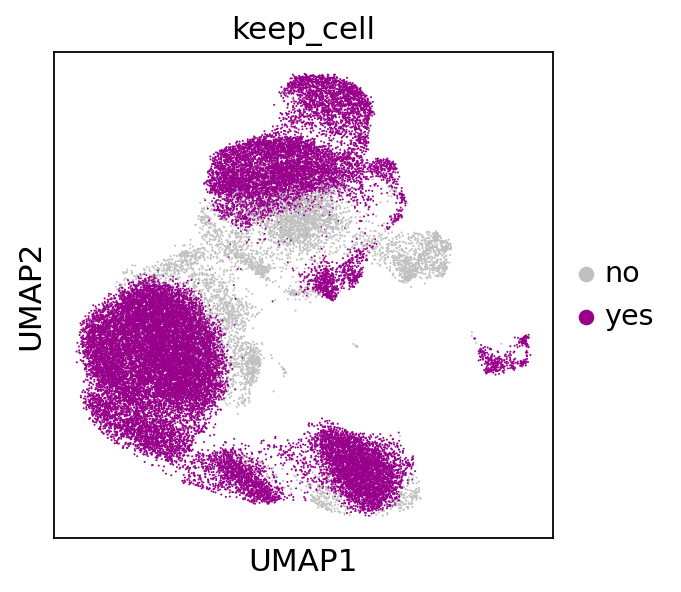

In [34]:
adata.uns['keep_cell_colors'] = [  "#C0C0C0", "#98008B"]
# quick pick at your cells to be removed
sc.pl.umap(
    adata, 
    color=['keep_cell'], 
    ncols=3,
    wspace = 0.3,
    sort_order = False
)

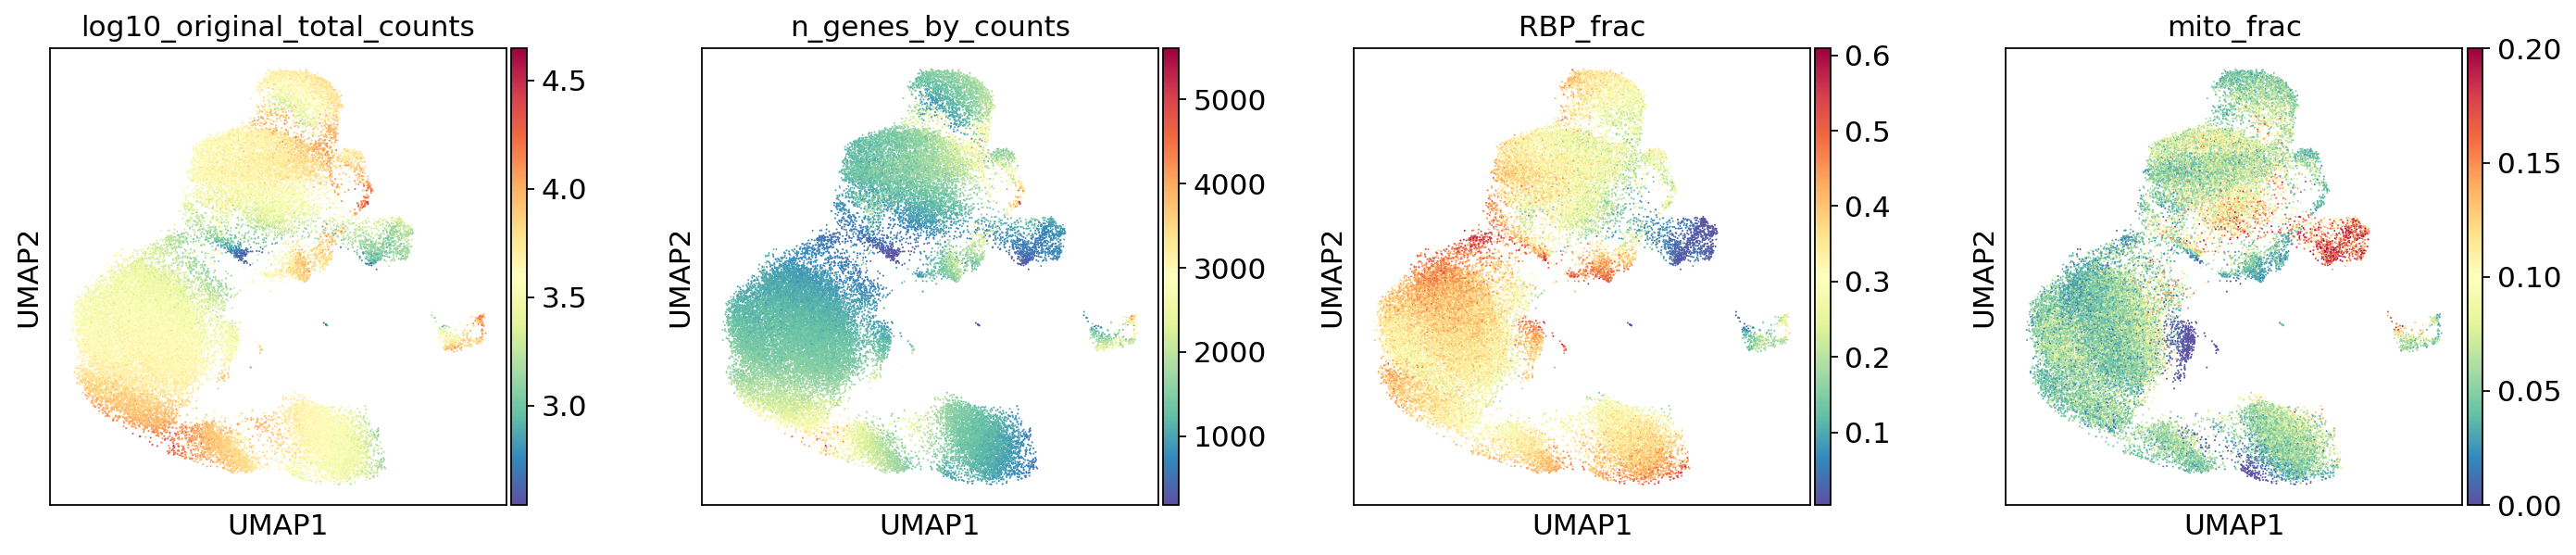

In [35]:
# inspect the QC metrics
sc.pl.umap(
    adata, 
    color=['log10_original_total_counts', 'n_genes_by_counts','RBP_frac', 'mito_frac'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

❗ This next command will remove bad quality cells.

In [36]:
adata = adata[adata.obs['QC']!=False]

In [37]:
# Remove doublet cells from annotation

Trying to set attribute `.uns` of view, copying.


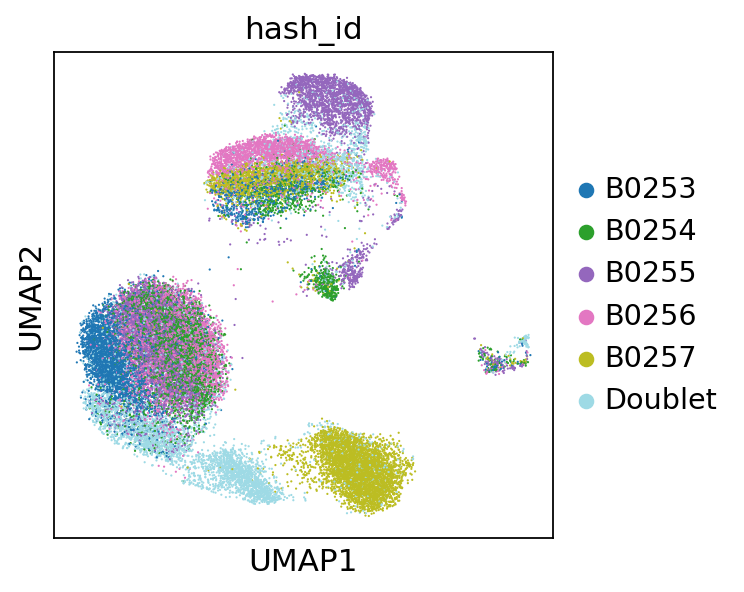

In [38]:
# inspect the QC metrics
sc.pl.umap(
    adata, 
    color=['hash_id'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

In [39]:
adata = adata[adata.obs['hash_id']!='Doublet']

Trying to set attribute `.uns` of view, copying.


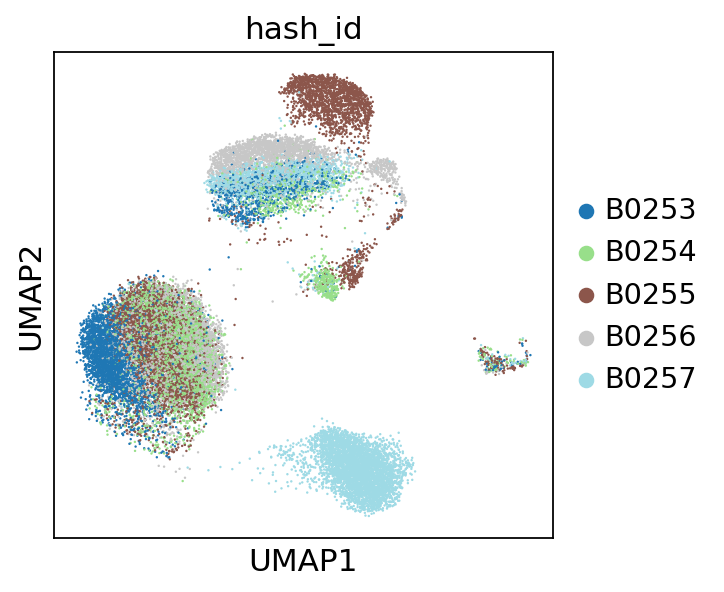

In [40]:
# inspect the QC metrics
sc.pl.umap(
    adata, 
    color=['hash_id'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

In [41]:
sc.settings.verbosity = 3 

In [42]:
sc.pp.highly_variable_genes(adata, flavor='seurat')

extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


### Let's have a look at the integrated data

In [47]:
rng = np.random.RandomState(42)
adata = sc.tl.pca(adata, n_comps=200, copy = True, svd_solver='arpack', random_state=rng)

computing PCA
    on highly variable genes
    with n_comps=200
    finished (0:00:15)


We can visualize the percentage of variance explained by each PC. Based on this figure, we will select a number of principal components to use in the rest of our analysis. 

<function matplotlib.pyplot.show(close=None, block=None)>

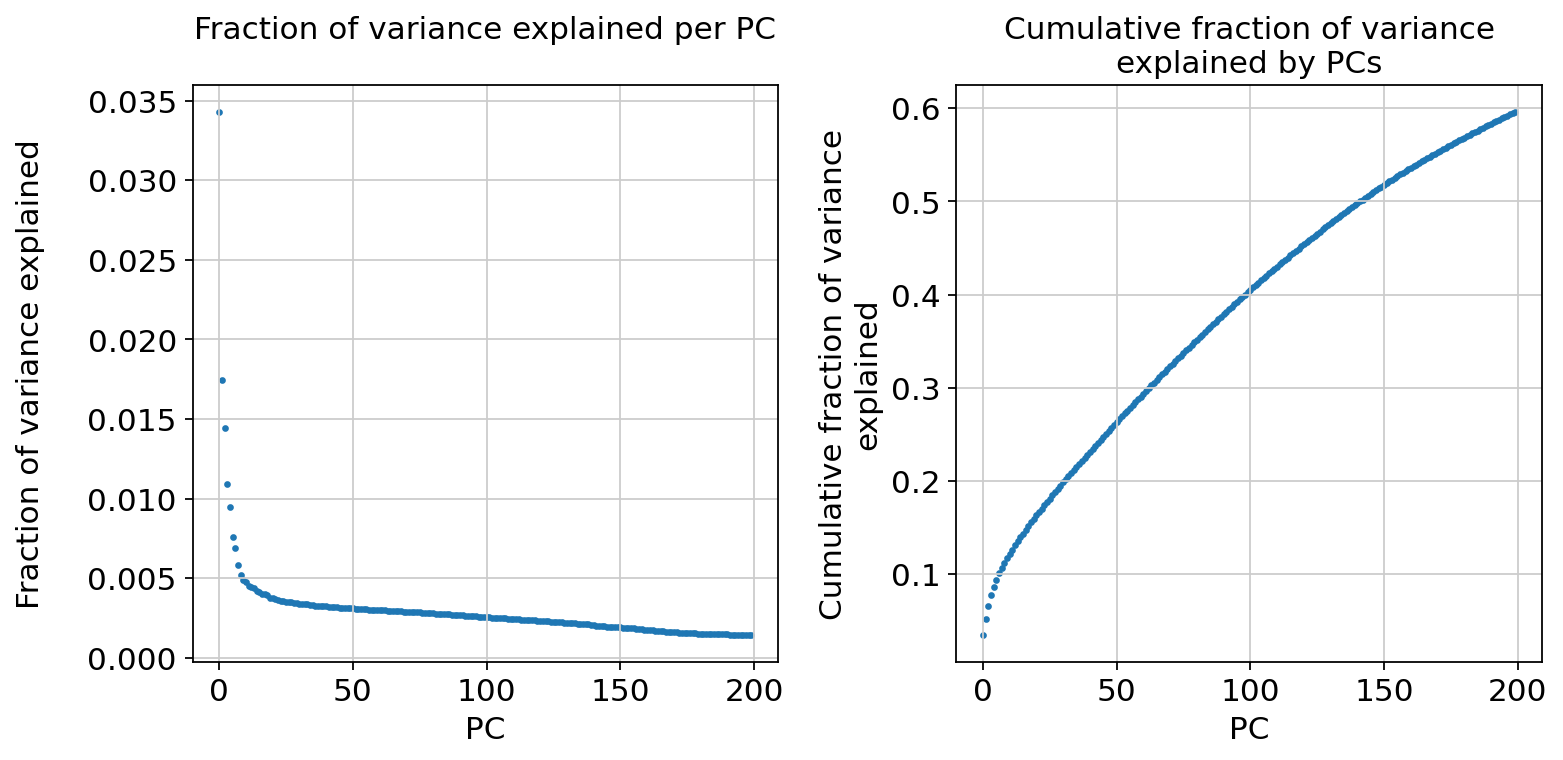

In [48]:
observe_variance(adata)

❗ We want to include all the principal components before the 'knee point' (the point where the fitted curve would change slope the most), because these likely represent important sources of variance in our data. To try to avoid eliminating any relevant but small sources of variance, we will choose a number of PCs slightly to the right of the knee point. 

Replace the number below with your selection and run PCA again.

In [73]:
rng = np.random.RandomState(42)
sc.tl.pca(adata, n_comps=30, svd_solver='arpack', random_state=rng)
sc.pp.neighbors(adata, n_neighbors=15)
sc.tl.umap(adata)

computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:30)


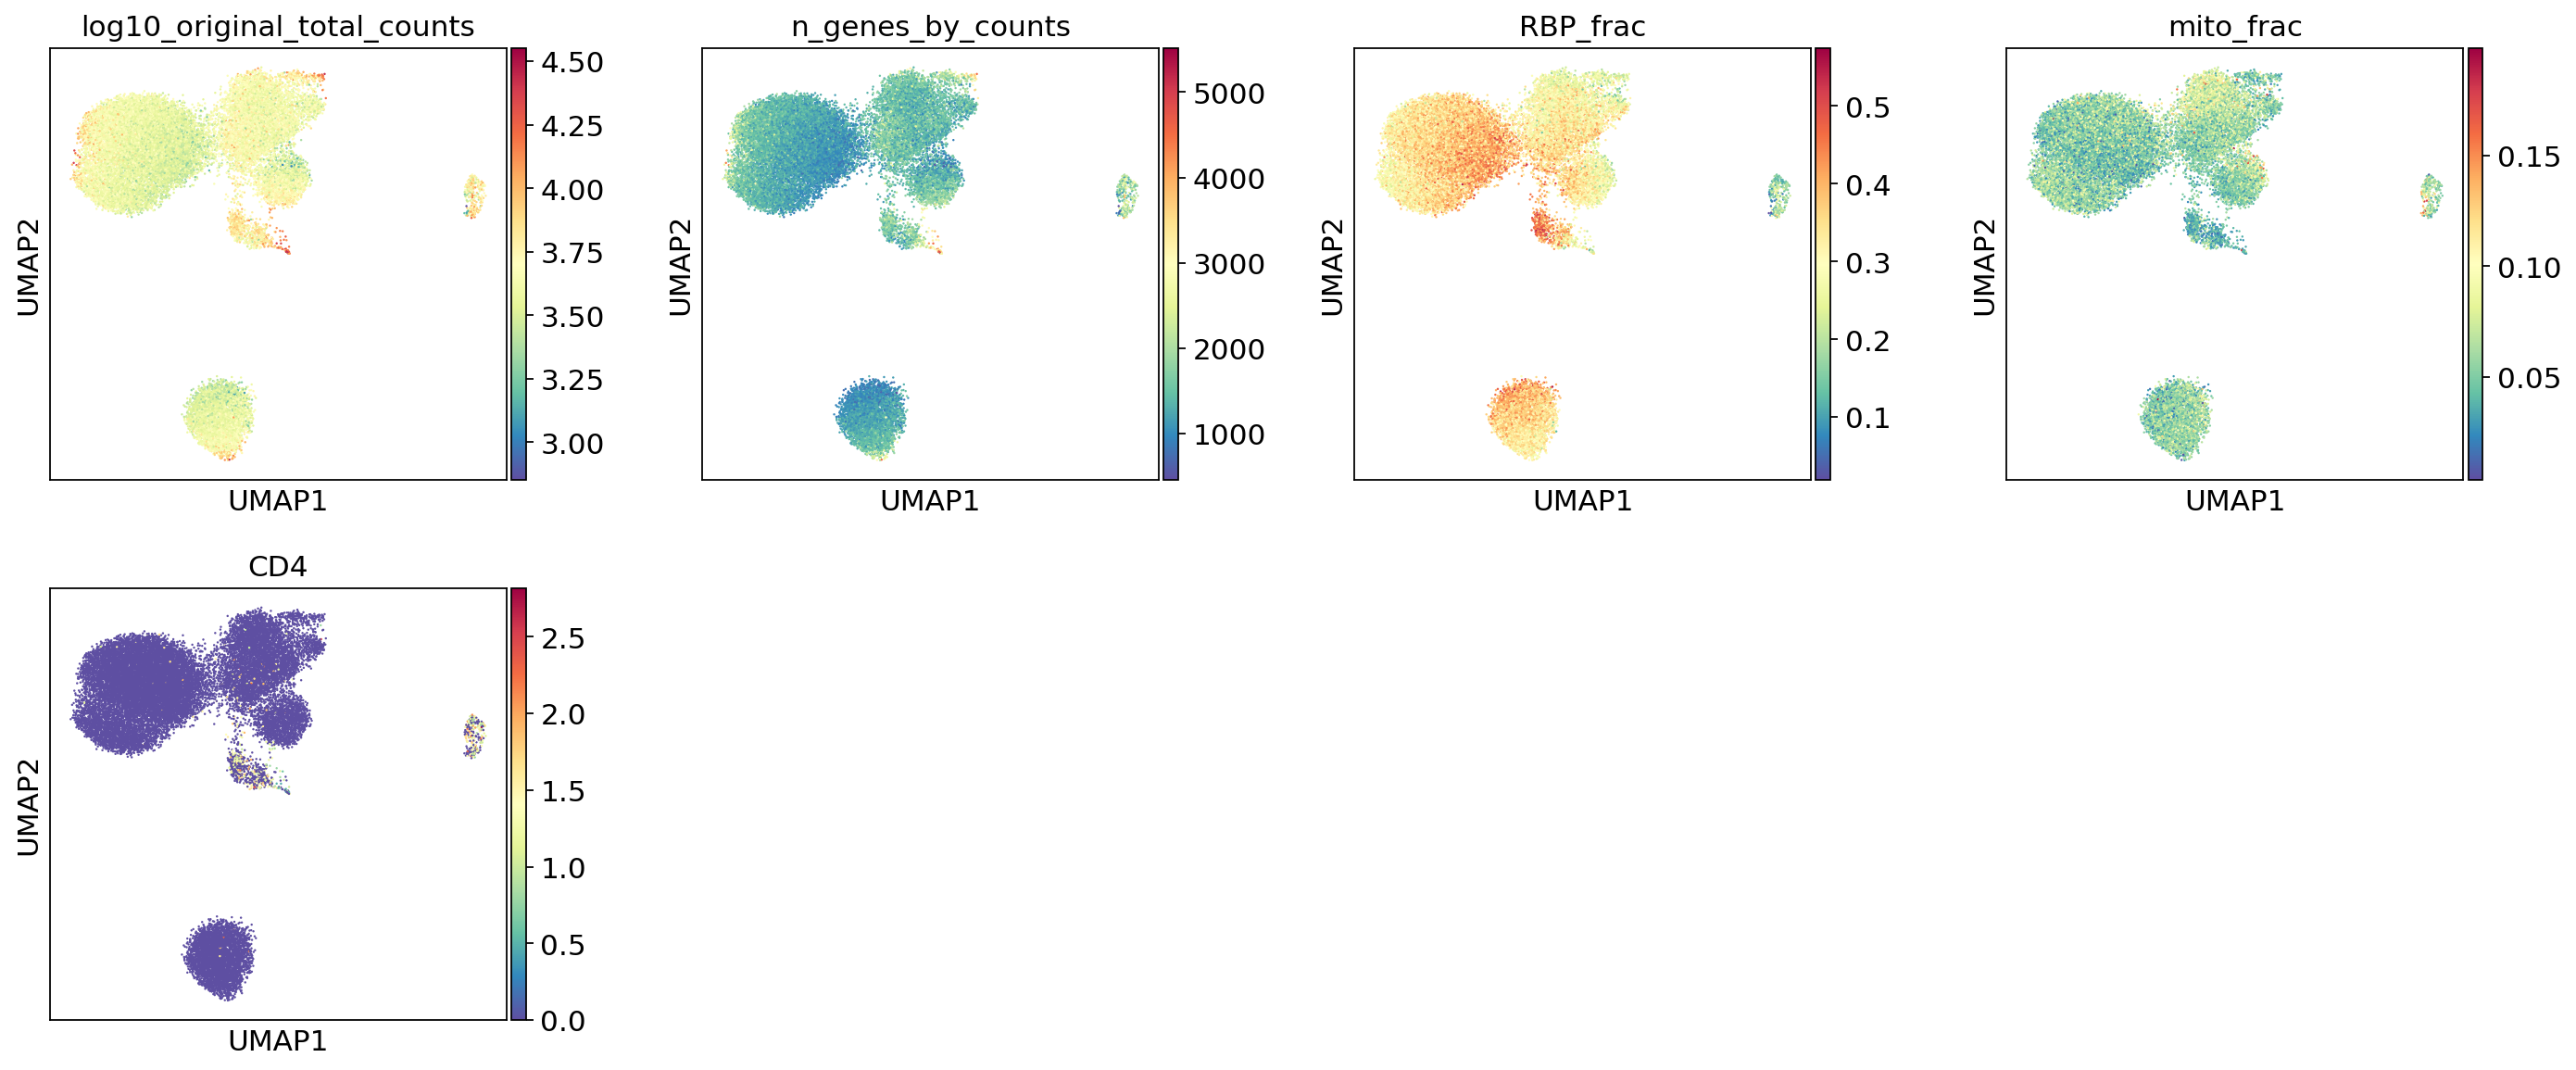

In [74]:
#30
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)

# inspect the QC metrics
sc.pl.umap(
    adata, 
    color=['log10_original_total_counts', 'n_genes_by_counts','RBP_frac', 'mito_frac', 'CD4'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

In [75]:
adata.obs['condition'] = ['healthy' if 'healthy' in x else 'patient' if 'patient' in x else 'ERROR' for x in adata.obs['sample']]

In [76]:
adata.uns['condition_colors'] = ['#B4C540', '#842D73']

/home/kousaa/miniconda3/envs/AK011_py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'condition' as categorical


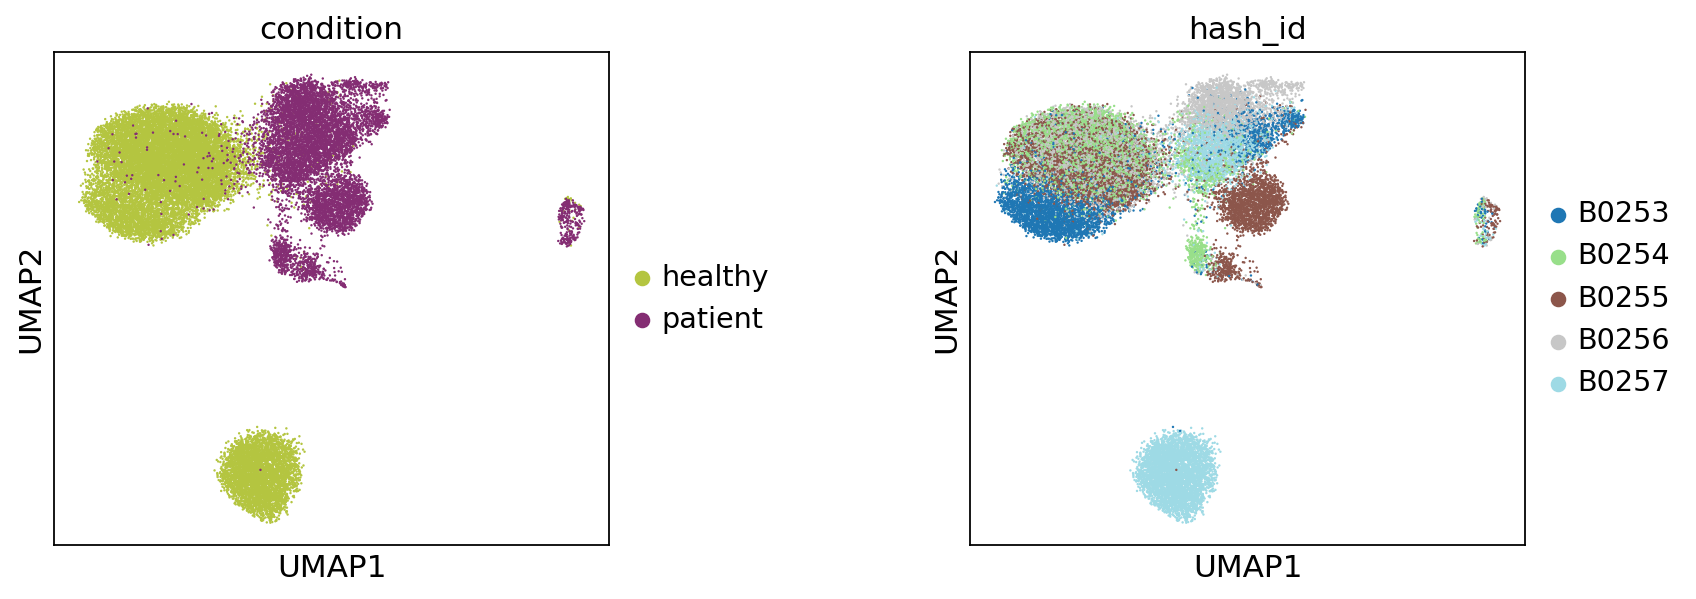

In [77]:
# inspect the QC metrics
sc.pl.umap(
    adata, 
    color=['condition', 'hash_id'], 
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.5,
    sort_order = False
)

### Unsupervised clustering analysis using PhenoGraph

In [78]:
# calculate clustering characteristics for a range of ks (5 to 155), by a step of 5.
ks = np.arange(5,155,5)
cluster_chars = [calc_clustering_characteristics(k, adata.obsm['X_pca']) for k in ks];

Finding 5 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 15.919843435287476 seconds
Jaccard graph constructed in 25.99857783317566 seconds
Wrote graph to binary file in 0.02548384666442871 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.943068
Louvain completed 21 runs in 9.142600297927856 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 59.39968514442444 seconds
Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 15.552956104278564 seconds
Jaccard graph constructed in 12.112295627593994 seconds
Wrote graph to binary file in 0.10010457038879395 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.791483
Louvain completed 21 runs in 8.876546621322632 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 45.42227292060852 seconds
Finding 15 nearest neighbors using minkowski metric 

Finding 95 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 15.0419282913208 seconds
Jaccard graph constructed in 80.91490840911865 seconds
Wrote graph to binary file in 1.4628965854644775 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.742726
Louvain completed 21 runs in 31.065942525863647 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 137.6025414466858 seconds
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 15.511643886566162 seconds
Jaccard graph constructed in 88.87496066093445 seconds
Wrote graph to binary file in 1.6039948463439941 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.742455
Louvain completed 21 runs in 36.81408381462097 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 152.46165990829468 seconds
Finding 105 nearest neighbors using minkowski metric 

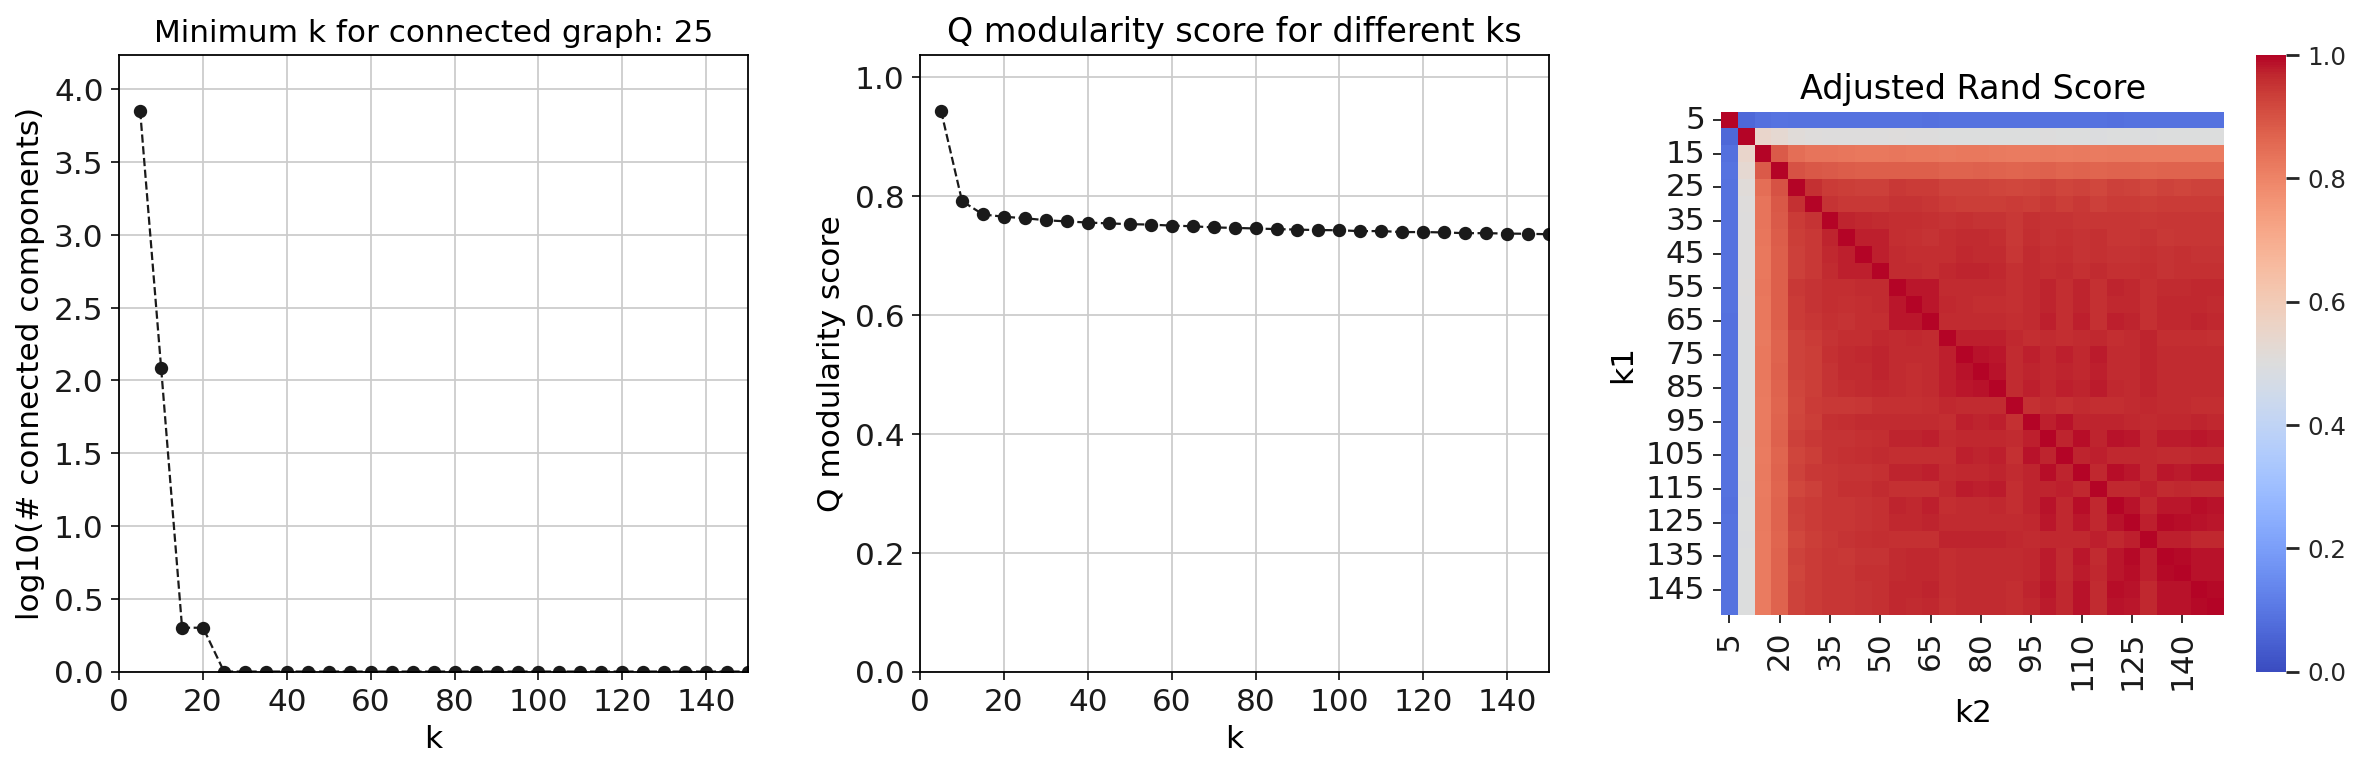

In [79]:
Rand_index_df = inspect_clustering_chars(ks, cluster_chars)

In [80]:
Rand_index_df.iloc[1:13,1:15]

k2,10,15,20,25,30,35,40,45,50,55,60,65,70,75
k1,,,,,,,,,,,,,,
10,1.000000,0.548203,0.533742,0.512605,0.506192,0.503259,0.501880,0.500321,0.500034,0.504152,0.503890,0.502980,0.499468,0.499009
15,0.548203,1.000000,0.885818,0.846320,0.835837,0.834194,0.832009,0.826564,0.827721,0.828802,0.828114,0.827229,0.821739,0.824241
20,0.533742,0.885818,1.000000,0.901073,0.886791,0.883283,0.879747,0.875314,0.875124,0.878770,0.878671,0.876890,0.870461,0.871026
25,0.512605,0.846320,0.901073,1.000000,0.954749,0.940901,0.935255,0.932171,0.931363,0.943775,0.939745,0.937685,0.926698,0.928423
30,0.506192,0.835837,0.886791,0.954749,1.000000,0.951802,0.944556,0.943852,0.942376,0.952074,0.950021,0.948793,0.939382,0.936978
35,0.503259,0.834194,0.883283,0.940901,0.951802,1.000000,0.970880,0.967851,0.964364,0.958579,0.957754,0.954019,0.951031,0.953515
40,0.501880,0.832009,0.879747,0.935255,0.944556,0.970880,1.000000,0.972921,0.974241,0.958353,0.954648,0.953053,0.959056,0.962731
45,0.500321,0.826564,0.875314,0.932171,0.943852,0.967851,0.972921,1.000000,0.975468,0.963274,0.960774,0.959276,0.959247,0.965343
50,0.500034,0.827721,0.875124,0.931363,0.942376,0.964364,0.974241,0.975468,1.000000,0.963784,0.962146,0.960101,0.967558,0.972646


In [81]:
# add your selected k value here to proceed
k=25
communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata.obsm['X_pca']),k=k)
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

PhenoGraph clustering
Finding 25 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 15.261398077011108 seconds
Jaccard graph constructed in 19.24307084083557 seconds
Wrote graph to binary file in 0.4568140506744385 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.762507
Louvain completed 21 runs in 15.356210708618164 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 60.19716119766235 seconds
    finished (0:01:00)


We can visualize the clustering to see which clusters match with the cells that we would like to filter out. Inspect the list of QC metrics and canonical markers to make your choice.

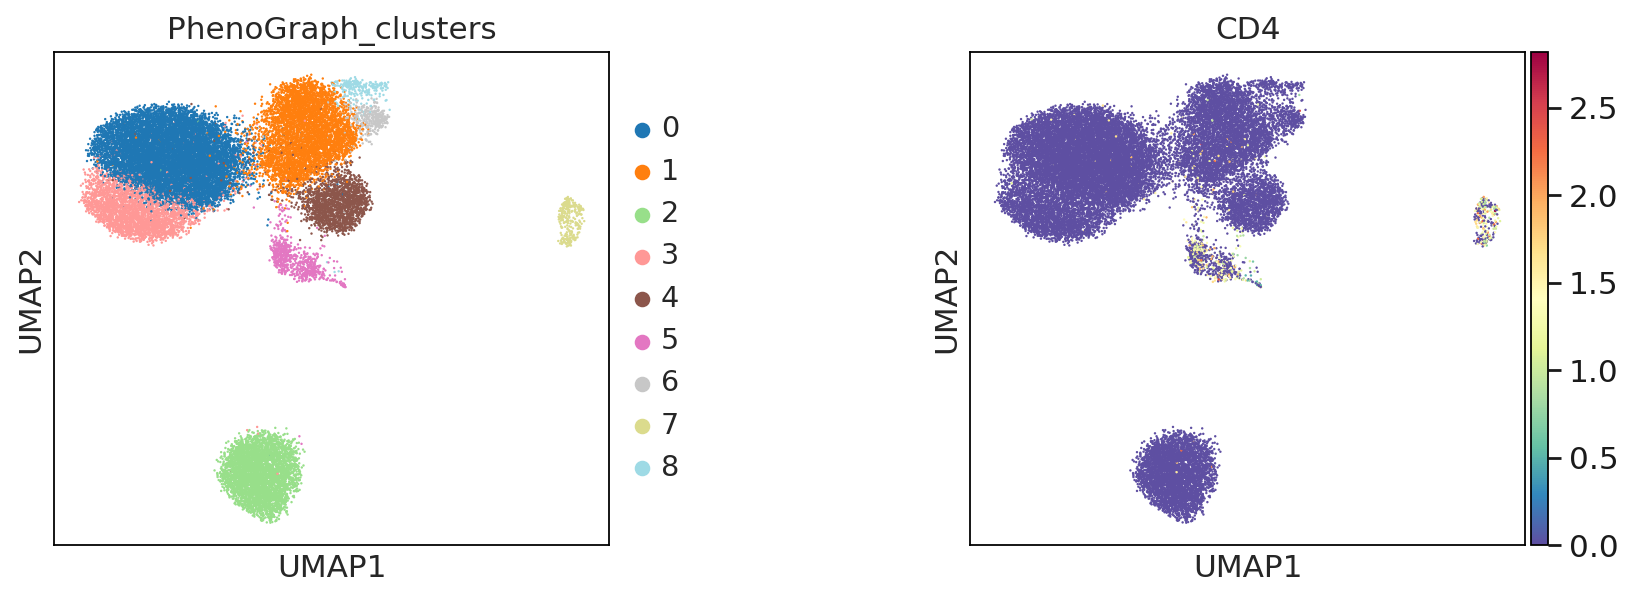

In [82]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters', 'CD4'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.5,
    sort_order = False
)

You are done! Just save your integrated file as an h5ad object. Make sure your path ends with the desired filename including the .h5ad file extension. You can now come back to this dataset at anytime.

In [83]:
path_to_h5ad = '/home/kousaa/scRNAseq-analysis/[AK011] Hana_unconvencional-Tcells/notebooks/files/MAIT.h5ad'

In [84]:
adata.write(path_to_h5ad)

In [5]:
adata = sc.read_h5ad(path_to_h5ad)

In [85]:
adata.shape

(25442, 19094)

In [86]:
%load_ext watermark

In [87]:
%watermark

Last updated: 2021-12-06T06:13:59.249951-05:00

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.29.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 3.10.0-957.12.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 72
Architecture: 64bit

